In [17]:
# dependências
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
df_dados = pd.read_excel("dataset se pa mais completo.xlsx", sheet_name="Mesclar1")

In [26]:
df_dados.head()

,Argos ID,GMT,Argos location class,Longitude,Latitude,Deploy year,Deploy date,End date,Tracking duration (days),Deploy location,...,Deploy longitude,Stage of annual cycle upon deployment,Sex,Maturity,Initial Activity,Number of locations,Tag programming,Retained for SSM,SSM derived track distance estimate (km),Movement captured
0,53348,2010-02-21 09:48:00,1,164246,-669,2010,2010-02-21,2010-03-24,31,Antarctica,...,1641775,On feeding grounds,Male,Adult,Feeding,118,4h on/8h off,Yes,1107.0,Antarctic feeding grounds
1,53348,2010-02-21 09:54:00,0,164224,-66883,2010,2010-02-21,2010-03-24,31,Antarctica,...,1641775,On feeding grounds,Male,Adult,Feeding,118,4h on/8h off,Yes,1107.0,Antarctic feeding grounds
2,53348,2010-02-21 11:20:00,B,164485,-66906,2010,2010-02-21,2010-03-24,31,Antarctica,...,1641775,On feeding grounds,Male,Adult,Feeding,118,4h on/8h off,Yes,1107.0,Antarctic feeding grounds
3,53348,2010-02-21 11:32:00,0,164489,-66882,2010,2010-02-21,2010-03-24,31,Antarctica,...,1641775,On feeding grounds,Male,Adult,Feeding,118,4h on/8h off,Yes,1107.0,Antarctic feeding grounds
4,53348,2010-02-21 11:33:00,B,163931,-66968,2010,2010-02-21,2010-03-24,31,Antarctica,...,1641775,On feeding grounds,Male,Adult,Feeding,118,4h on/8h off,Yes,1107.0,Antarctic feeding grounds


Definição da target: Initial Activity

Features: Deploy Location, Stage of annual cycle upon deployment, Sex, Maturity, SSM derived track distante estimate

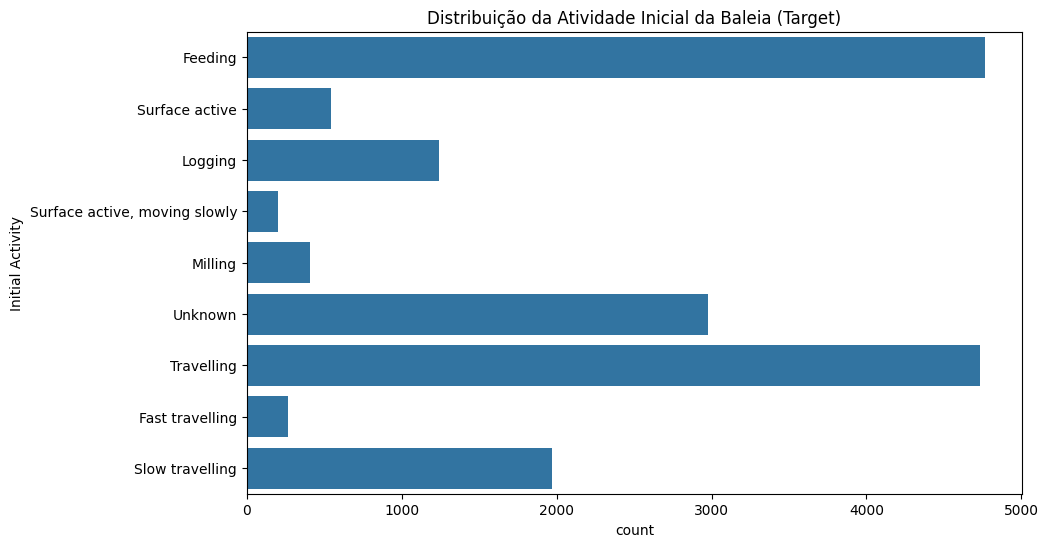

Initial Activity
Feeding                          4766
Travelling                       4735
Unknown                          2977
Slow travelling                  1967
Logging                          1240
Surface active                    546
Milling                           408
Fast travelling                   268
Surface active, moving slowly     199
Name: count, dtype: int64


In [36]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df_dados['Initial Activity'])
plt.title('Distribuição da Atividade Inicial da Baleia (Target)')
plt.show() # 

# Verifique a proporção:
print(df_dados['Initial Activity'].value_counts())

In [ ]:
# Porcentagem de valores faltantes por coluna
print(df_dados.isnull().sum() / len(df_dados) * 100)

Argos ID                                    0.000000
GMT                                         0.000000
Argos location class                        0.000000
Longitude                                   0.000000
Latitude                                    0.000000
Deploy year                                 0.000000
Deploy date                                 0.000000
End date                                    0.000000
Tracking duration (days)                    0.000000
Deploy location                             0.000000
Deploy latitude                             0.000000
Deploy longitude                            0.000000
Stage of annual cycle upon deployment       0.000000
Sex                                         0.000000
Maturity                                    0.000000
Initial Activity                            0.000000
Number of locations                         0.000000
Tag programming                             0.000000
Retained for SSM                            0.

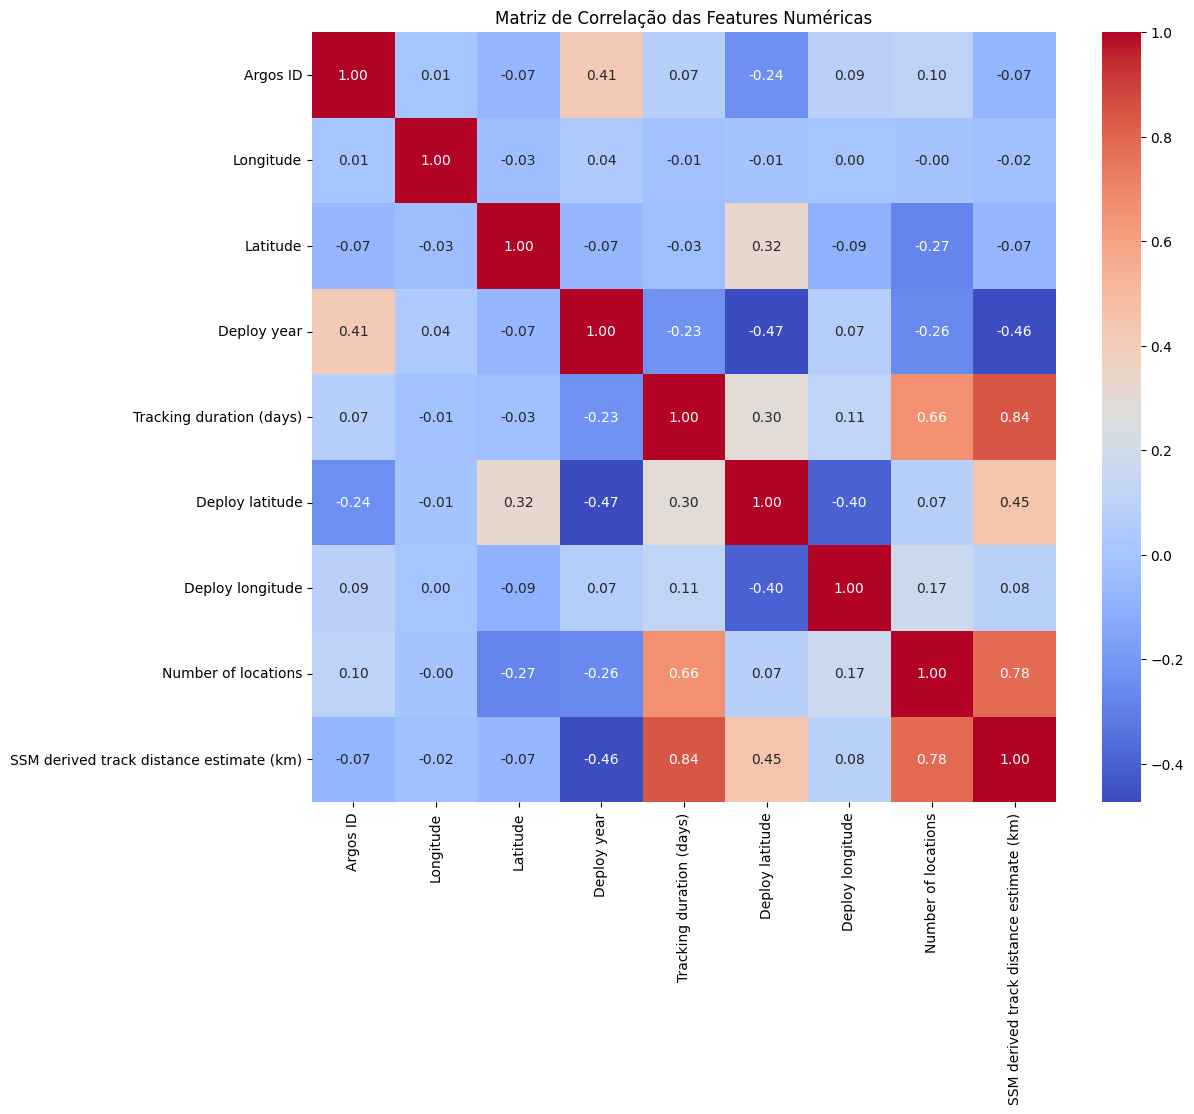

In [38]:
# Selecionar apenas colunas numéricas
numeric_cols = df_dados.select_dtypes(include=np.number).columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_dados[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Features Numéricas')
plt.show() #

In [ ]:
# 1. Definir tipos de colunas
numerical_features = ['Longitude', 'Latitude'] # Exemplo
categorical_features = ['Sex', 'Maturity', 'Deploy location', 'Stage of annual cycle upon deployment', 'Movement captured'] # Exemplo

for col in categorical_features:
    # Usa .astype(str) para garantir que tudo seja tratado como string
    df_dados[col] = df_dados[col].astype(str)

X = df_dados.drop('Initial Activity', axis=1)
y = df_dados['Initial Activity']

# O parâmetro 'stratify=y' é OBRIGATÓRIO para garantir o balanceamento nas amostras
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [63]:
# 2. Criar transformadores
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Preenche NaNs com mediana
    ('scaler', StandardScaler()) # Padroniza os dados (média 0, desvio 1)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Preenche NaNs com a moda
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Converte categorias em colunas (One-Hot)
])

# 3. Combinar transformadores (ColumnTransformer)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Remove quaisquer outras colunas não listadas (como datas ou IDs)
)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer # Importação necessária para o Pipeline

# --- Modelo 1: Regressão Logística ---
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

param_grid_lr = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train, y_train)
print(f"Melhores parâmetros LR: {grid_lr.best_params_}")
best_lr = grid_lr.best_estimator_

# --- Modelo 2: Random Forest ---
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(random_state=42))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1_macro', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print(f"Melhores parâmetros RF: {grid_rf.best_params_}")
best_rf = grid_rf.best_estimator_

# --- Modelo 3: K-Nearest Neighbors ---
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='f1_macro', n_jobs=-1)
grid_knn.fit(X_train, y_train)
print(f"Melhores parâmetros KNN: {grid_knn.best_params_}")
best_knn = grid_knn.best_estimator_

Melhores parâmetros LR: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}
Melhores parâmetros RF: {'classifier__max_depth': None, 'classifier__n_estimators': 100}
Melhores parâmetros KNN: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}


In [65]:
# Lista dos modelos para avaliação
models = {
    'Logistic Regression': best_lr,
    'Random Forest': best_rf,
    'K-Nearest Neighbors': best_knn
}

results = {}

for name, model in models.items():
    # Fazer predição no conjunto de TESTE (dados não vistos!)
    y_pred = model.predict(X_test)

    # Calcular as métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    results[name] = {
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Recall (Macro)': recall_macro,
        'F1-Score (Macro)': f1_macro
    }

# 1. Tabela de Métricas (para a Seção 4 do Relatório)
results_df = pd.DataFrame(results).T
print("\n--- Resultados de Avaliação (Conjunto de Teste) ---")
print(results_df.sort_values(by='F1-Score (Macro)', ascending=False))


--- Resultados de Avaliação (Conjunto de Teste) ---
                     Accuracy  Precision (Macro)  Recall (Macro)  \
K-Nearest Neighbors  0.970777           0.950596        0.950727   
Random Forest        0.969316           0.959769        0.939297   
Logistic Regression  0.756283           0.509965        0.472042   

                     F1-Score (Macro)  
K-Nearest Neighbors          0.950238  
Random Forest                0.948467  
Logistic Regression          0.470031  


O melhor modelo selecionado para análise detalhada é: K-Nearest Neighbors


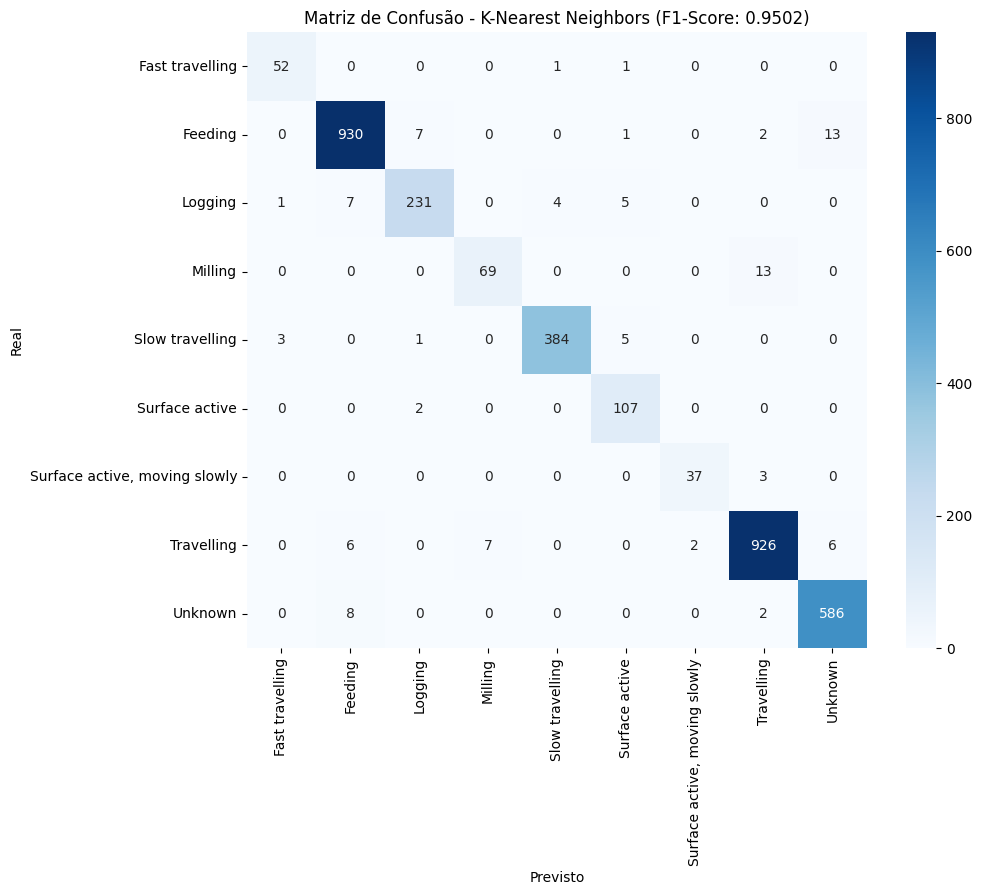

In [67]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Escolher o melhor modelo usando a melhor métrica (F1-Score)
# O idxmax() encontra a linha com o valor máximo na coluna, que será 'K-Nearest Neighbors'
best_model_name = results_df['F1-Score (Macro)'].idxmax()
best_model = models[best_model_name]
print(f"O melhor modelo selecionado para análise detalhada é: {best_model_name}")

# Fazer a predição no conjunto de TESTE
y_pred_best = best_model.predict(X_test)

# Definir as classes (rótulos) para a Matriz de Confusão
# É importante usar os rótulos que o modelo conhece (y_train)
classes = sorted(y_train.unique())

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_best, labels=classes) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - {best_model_name} (F1-Score: {results_df.loc[best_model_name, "F1-Score (Macro)"]:.4f})')
plt.show() #

In [73]:
# 1. Encontrar o índice da classe 'Travelling' na ordem alfabética
# Lembre-se que as classes foram definidas como: classes = sorted(y_train.unique())
classes = sorted(y_train.unique())
try:
    # O nome da classe no seu dataset é 'Travelling', com 'll'.
    traveling_index = classes.index('Travelling') 
except ValueError:
    # Se houver erro, pode ser que o nome seja diferente, tente outra forma:
    print("Atenção: 'Travelling' não foi encontrado. Verifique o nome exato da classe.")
    traveling_index = -1 # Se não encontrar, interrompe a análise específica

if traveling_index != -1:
    i = traveling_index
    
    # 2. Extrair os valores brutos da Matriz de Confusão (cm)
    
    # VP (Verdadeiros Positivos): Casos em que Real=Travelling e Previsto=Travelling
    VP_Traveling = cm[i, i] 
    
    # FN (Falsos Negativos): Casos em que Real=Travelling, mas Previsto=Outra Coisa
    # Soma de toda a linha 'i' (Total Real) menos o VP
    Total_Real_Traveling = cm[i, :].sum()
    FN_Traveling = Total_Real_Traveling - VP_Traveling
    
    # FP (Falsos Positivos): Casos em que Real=Outra Coisa, mas Previsto=Travelling
    # Soma de toda a coluna 'i' (Total Previsto) menos o VP
    Total_Previsto_Traveling = cm[:, i].sum()
    FP_Traveling = Total_Previsto_Traveling - VP_Traveling
    
    # 3. Gerar a Interpretação Concreta Conforme o Requisito
    
    print("\n--- Interpretação Concreta do KNN para a classe 'Travelling' ---")
    
    # Exemplo 1: Focado no Recall (o que é o requisito principal)
    print(f"O modelo classificou corretamente {VP_Traveling} casos de 'Travelling'.")
    print(f"Isto significa que, de um total de {Total_Real_Traveling} baleias que estavam 'Travelling' na realidade,")
    print(f"o modelo acertou {VP_Traveling} vezes, resultando em {FN_Traveling} Falsos Negativos.")
    
    # Exemplo 2: Focado na Precision (complemento de interpretação)
    print(f"\nEm termos de precisão, de todos os {Total_Previsto_Traveling} casos que o modelo previu como 'Travelling',")
    print(f"{VP_Traveling} estavam corretos e {FP_Traveling} foram classificados erroneamente como 'Travelling' (Falsos Positivos).")

    # --- 1. Análise da Classe Majoritária: 'Feeding' ---

try:
    feeding_index = classes.index('Feeding') 
    i = feeding_index
    
    # Extração dos valores
    VP_Feeding = cm[i, i] 
    Total_Real_Feeding = cm[i, :].sum()
    FN_Feeding = Total_Real_Feeding - VP_Feeding
    Total_Previsto_Feeding = cm[:, i].sum()
    FP_Feeding = Total_Previsto_Feeding - VP_Feeding
    
    print("\n--- Interpretação Concreta do KNN para a classe 'Feeding' (Majoritária) ---")
    
    # Exemplo de Interpretação (com foco na eficiência)
    print(f"1. Casos Reais de 'Feeding': {Total_Real_Feeding}")
    print(f"2. O modelo classificou corretamente {VP_Feeding} casos de 'Feeding' (Verdadeiros Positivos).")
    print(f"3. O número de vezes que o modelo falhou em identificar uma baleia 'Feeding' foi de {FN_Feeding} (Falsos Negativos).")
    print(f"4. A **Precision** do modelo em prever 'Feeding' foi muito alta, com apenas {FP_Feeding} Falsos Positivos.")

except ValueError:
    print("\nClasse 'Feeding' não encontrada. Verifique o nome exato.")


# --- 2. Análise da Classe Minoritária: 'Surface active, moving slowly' ---

try:
    minor_index = classes.index('Surface active, moving slowly')
    i = minor_index
    
    # Extração dos valores
    VP_Minor = cm[i, i] 
    Total_Real_Minor = cm[i, :].sum()
    FN_Minor = Total_Real_Minor - VP_Minor
    Total_Previsto_Minor = cm[:, i].sum()
    FP_Minor = Total_Previsto_Minor - VP_Minor
    
    print("\n--- Interpretação Concreta do KNN para a classe 'Surface active, moving slowly' (Minoritária) ---")
    
    # Exemplo de Interpretação (com foco nos desafios do desbalanceamento)
    print(f"1. Casos Reais de 'Surface active, moving slowly': {Total_Real_Minor}")
    print(f"2. O modelo classificou corretamente {VP_Minor} casos (Verdadeiros Positivos).")
    print(f"3. Devido ao pequeno volume de dados, a dificuldade é maior: o modelo errou ao prever {FN_Minor} casos (Falsos Negativos).")
    print(f"4. O modelo previu {FP_Minor} baleias como 'Surface active, moving slowly' erroneamente (Falsos Positivos).")
    
except ValueError:
    print("\nClasse 'Surface active, moving slowly' não encontrada. Verifique o nome exato.")


--- Interpretação Concreta do KNN para a classe 'Travelling' ---
O modelo classificou corretamente 926 casos de 'Travelling'.
Isto significa que, de um total de 947 baleias que estavam 'Travelling' na realidade,
o modelo acertou 926 vezes, resultando em 21 Falsos Negativos.

Em termos de precisão, de todos os 946 casos que o modelo previu como 'Travelling',
926 estavam corretos e 20 foram classificados erroneamente como 'Travelling' (Falsos Positivos).

--- Interpretação Concreta do KNN para a classe 'Feeding' (Majoritária) ---
1. Casos Reais de 'Feeding': 953
2. O modelo classificou corretamente 930 casos de 'Feeding' (Verdadeiros Positivos).
3. O número de vezes que o modelo falhou em identificar uma baleia 'Feeding' foi de 23 (Falsos Negativos).
4. A **Precision** do modelo em prever 'Feeding' foi muito alta, com apenas 21 Falsos Positivos.

--- Interpretação Concreta do KNN para a classe 'Surface active, moving slowly' (Minoritária) ---
1. Casos Reais de 'Surface active, moving sl

Abaixo é um teste para ver se o modelo muda as respostas previstas

In [70]:
novo_dado = pd.DataFrame({
    'Argos PTT': [77795], 
    'GMT': ['2026-01-01 12:00:00'], 
    'Argos location class': ['A'], 
    'Longitude': [-50.123], 
    'Latitude': [-30.456], 
    'Deploy location': ['Atlantico Sul'],
    'Sex': ['Female'],
    'Maturity': ['Calf'],
    'Stage of annual cycle upon deployment': ['Migrating south'],
    'Movement captured': ['Antarctic feeding grounds']
})

In [71]:
# O modelo best_knn é o seu pipeline completo (pré-processador + classificador)
best_model = best_knn 

# Fazer a predição da classe (Feeding, Travelling, etc.)
predicao_classe = best_model.predict(novo_dado)

# Fazer a predição das probabilidades (confiança do modelo em cada classe)
predicao_proba = best_model.predict_proba(novo_dado)

print(f"A atividade inicial prevista para a nova baleia é: {predicao_classe[0]}")

A atividade inicial prevista para a nova baleia é: Slow travelling
